# Project 3 OpenClassRooms - Notebook 1
Letizia Pichon

## 1. Import Libraries and data

In [1]:
import glob
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm 

tqdm.pandas()

In [2]:
data = pd.read_csv('data/products.csv', sep='\t', encoding='utf-8')
print('Shape of data Table: ', data.shape)

# delete products that are not sold in France
data = data[data['countries_en'].str.contains('france', case=False, na=False)]  

print('Shape of data Table : ', data.shape)

C:\Users\letiz\miniconda3\envs\factonics\lib\site-packages\IPython\core\interactiveshell.py:3437: DtypeWarning: Columns (0,8,13,22,23,27,28,29,31,52,55,64) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Shape of data Table:  (1928697, 186)
Shape of data Table :  (831216, 186)


## 2. Keep interesting columns

In [3]:
# divide df in two dfs 
info = data.loc[:,'code':'image_nutrition_small_url' ]
nutriments = data.loc[:,'energy-kj_100g':'carnitine_100g']
print(f"Info shape: {info.shape} \nnutriment shape: {nutriments.shape}")

Info shape: (831216, 75) 
nutriment shape: (831216, 111)


In [4]:
del data

### 2.1 Filter on Informations columns

#### 2.1.1 Delete columns with more that 70% of nulls

In [5]:
# calculate ratio of null values for each column
percent_missing = info.isnull().mean()
missing_info = pd.DataFrame({'column_name': info.columns,
                                 'ratio_nan': percent_missing})
# select columns to delete
col2delete = missing_info[missing_info['ratio_nan']>0.7]['column_name'].to_list()
print('Number of columns to delete : ', len(col2delete))

# filter on df
info.drop(columns=col2delete, inplace=True)

print('Shape of info table : ', info.shape)

Number of columns to delete :  34
Shape of info table :  (831216, 41)


#### 2.1.2 Delete duplicates columns keeping only columns with "_en"

In [6]:
# find all columns containing "_en"
regex = "_en"
en = info.columns[info.columns.str.contains(regex)].to_list()
en

['categories_en', 'labels_en', 'countries_en', 'states_en', 'main_category_en']

In [7]:
en = ['categories_en', 'labels_en', 'countries_en', 'states_en', 'main_category_en']
list_with_en = ['categories', 'labels', 'countries', 'states', 'main_category']

In [8]:
# find all columns that are duplicates of columns containing '_en' and keep only columns with '_en'
col2delete = []
list_with_en = []

# find the original column name
for el in en: 
    list_with_en.append(el.replace('_en',''))

# find all the column that have the same name of the en columns and delete them
for element in list_with_en: 
    l = info.columns[info.columns.str.contains(element)].to_list()
    for el in l: 
        if ('_en' not in el) and ('_n' not in el):
            col2delete.append(el)

info.drop(columns=col2delete, inplace=True)
print('Shape of info table : ', info.shape)

Shape of info table :  (831216, 32)


#### 2.1.3 Investigate categories columns

4 columns give informations about the product type. We need to keep only one column

In [9]:
print('Categories_en: ', info['categories_en'].nunique(), 'categories')
print('Main_category_en: ', info['main_category_en'].nunique(), 'categories')

info.pnns_groups_1.replace('unknown', np.nan, inplace=True)
info.pnns_groups_2.replace('unknown', np.nan, inplace=True)
print('Pnns_groups_1: ', info['pnns_groups_1'].nunique(), 'categories')
print('Pnns_groups_2: ', info['pnns_groups_2'].nunique(), 'categories')

Categories_en:  44512 categories
Main_category_en:  18377 categories
Pnns_groups_1:  11 categories
Pnns_groups_2:  41 categories


#### 2.1.4 Delete columns with selected tags

In [10]:
to_delete = ["image", 'url', 'created', 'creator', 'modified', 'additives',
             'tags', 'states', 'ingredients', 'quantity', 'kj']
columns2delete = info.columns[info.columns.str.contains("|".join(to_delete), regex=True, case=False, na=False)].to_list()
columns2delete.remove('image_url')

info.drop(columns=columns2delete,inplace=True)  
print('Shape of info table : ', info.shape)

Shape of info table :  (831216, 14)


<AxesSubplot:>

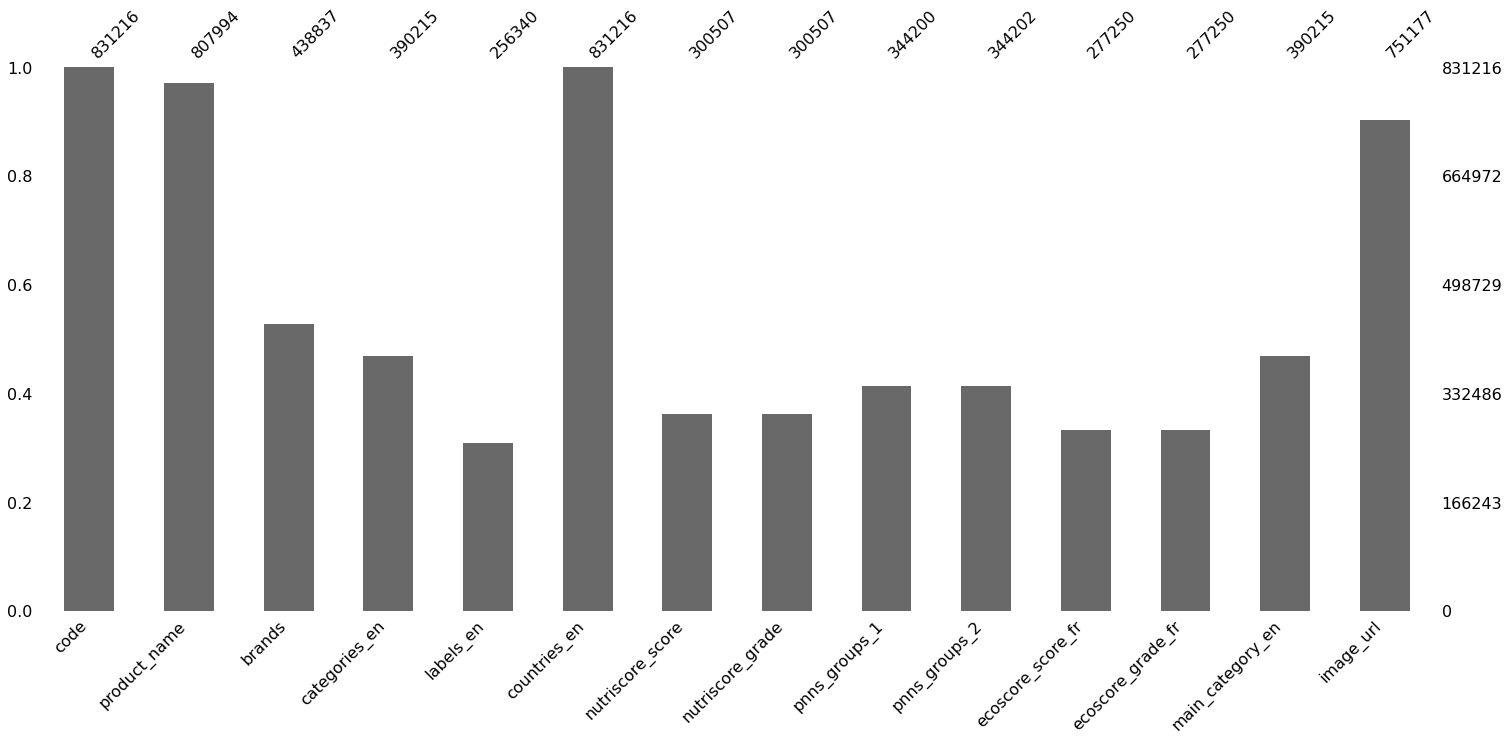

In [11]:
msno.bar(info)

### 2.2 Filter on nutriments columns

#### 2.2.1 Delete columns that have more than 70% of null values

In [12]:
nutriments.shape[0]
nan_nutr = nutriments.isna().sum().reset_index()
nan_nutr.rename(columns = {0: 'nan_count'}, inplace=True)
nan_nutr['values'] = nutriments.shape[0] - nan_nutr['nan_count']
nan_nutr['ratio_nan'] = nan_nutr['nan_count'] / nutriments.shape[0]

col2keep = nan_nutr[nan_nutr['ratio_nan'] < 0.3]['index'].to_list()

nutriments = nutriments[col2keep]

<AxesSubplot:>

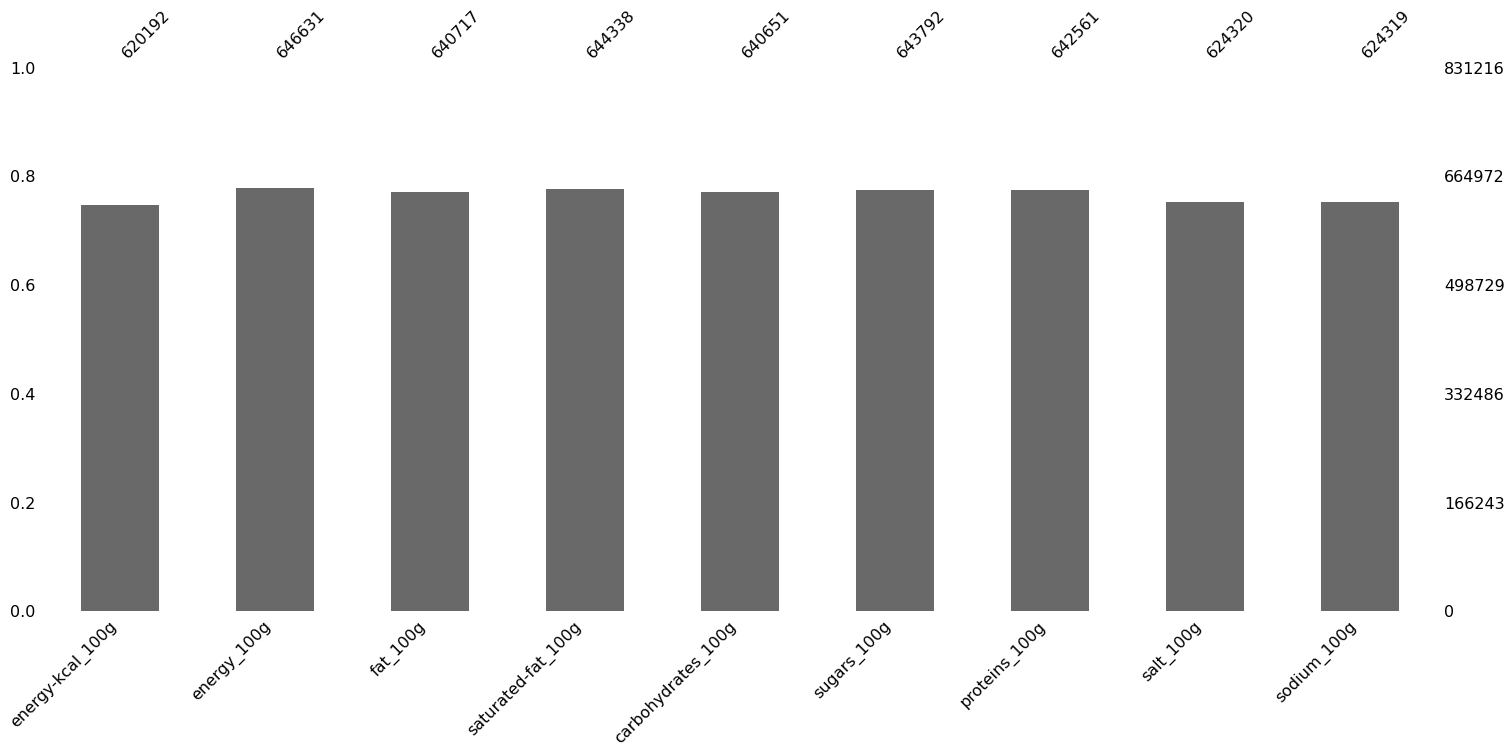

In [13]:
msno.bar(nutriments)

### 2.3 Concat dfs

In [14]:
data = pd.concat([info, nutriments], axis=1)

## 3. Clean Data

### 3.1 Delete rows

#### 3.1.1 Delete not usable rows

In [15]:
print('Shape of data table : ', data.shape)

data = data.drop_duplicates()
data = data[data['product_name'].notnull()]

print('Shape of data table after first cleaning: ', data.shape)

Shape of data table :  (831216, 23)
Shape of data table after first cleaning:  (807994, 23)


#### 3.1.2 Delete rows with more that 50% of nulls

In [16]:
data['ratio_null'] = data.isnull().mean(axis=1)
data = data[data['ratio_null'] < 0.5]

del data['ratio_null']
print('Shape of data table after first cleaning: ', data.shape)

Shape of data table after first cleaning:  (638744, 23)


#### 3.1.3 Clean nutriments columns

In [17]:
# find nutriments columns without energy columns
nutriments = data.columns[data.columns.str.contains('100g')].to_list()[2:]

#delete all rows with ourliers
for el in nutriments: 
    data[el] = data[el].fillna(0)
    outliers = data[el].mean() + 2 * data[el].std()
    if  outliers > 100 : 
        outliers = 100
    data = data[data[el].between(0, outliers, inclusive = "both")]  # MD: both instead of True

# delete rows with not coherent data 
data = data[data['saturated-fat_100g'] < data['fat_100g']]  
data = data[data['sugars_100g'] < data['carbohydrates_100g']]
data = data[data['sodium_100g'] < data['salt_100g']] 
# https://sante.journaldesfemmes.fr/fiches-sante-du-quotidien/2657523-quels-aliments-les-plus-caloriques-a-eviter/#:~:text=L'aliment%20%C3%A0%20la%20densit%C3%A9,et%20apporte%20900%20calories%2F100g.
data = data[(data['energy-kcal_100g'] <= 900) | (data['energy-kcal_100g'].isnull())]
print('Shape of data table after first cleaning: ', data.shape)

Shape of data table after first cleaning:  (319193, 23)


#### 3.1.4 Investigate if we can predict energy-kcal_100g column from energy_100g

energy-kcal_100g has a lot more null values that energy_100g and we find a very strong correlation between these two columns

In [18]:
corr = data.corr()
corr.style.background_gradient(cmap='coolwarm')


,nutriscore_score,ecoscore_score_fr,energy-kcal_100g,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,proteins_100g,salt_100g,sodium_100g
nutriscore_score,1.000000,-0.322100,0.593665,0.147449,0.598467,0.749346,0.246360,0.473283,0.050507,0.348262,0.348250
ecoscore_score_fr,-0.322100,1.000000,-0.190189,-0.037449,-0.336620,-0.303872,0.189300,-0.034699,-0.384261,-0.185392,-0.185373
energy-kcal_100g,0.593665,-0.190189,1.000000,0.996223,0.724463,0.517563,0.573590,0.399259,0.266129,0.043259,0.043259
energy_100g,0.147449,-0.037449,0.996223,1.000000,0.241625,0.172911,0.195089,0.133320,0.089559,0.016360,0.016357
fat_100g,0.598467,-0.336620,0.724463,0.241625,1.000000,0.636393,0.015961,0.159520,0.240561,0.186604,0.186598
saturated-fat_100g,0.749346,-0.303872,0.517563,0.172911,0.636393,1.000000,0.102161,0.325457,0.176847,0.080317,0.080315
carbohydrates_100g,0.246360,0.189300,0.573590,0.195089,0.015961,0.102161,1.000000,0.558953,-0.091543,-0.204493,-0.204504
sugars_100g,0.473283,-0.034699,0.399259,0.133320,0.159520,0.325457,0.558953,1.000000,-0.237575,-0.358946,-0.358975
proteins_100g,0.050507,-0.384261,0.266129,0.089559,0.240561,0.176847,-0.091543,-0.237575,1.000000,0.266997,0.267007
salt_100g,0.348262,-0.185392,0.043259,0.016360,0.186604,0.080317,-0.204493,-0.358946,0.266997,1.000000,0.999983


In [19]:
data.isnull().sum().sort_values()

code                       0
proteins_100g              0
sugars_100g                0
carbohydrates_100g         0
saturated-fat_100g         0
fat_100g                   0
salt_100g                  0
sodium_100g                0
countries_en               0
product_name               0
energy_100g              287
energy-kcal_100g       15397
image_url              21391
brands                129064
main_category_en      154936
categories_en         154936
nutriscore_score      159655
nutriscore_grade      159655
pnns_groups_1         169692
pnns_groups_2         169692
labels_en             202038
ecoscore_score_fr     204228
ecoscore_grade_fr     204228
dtype: int64

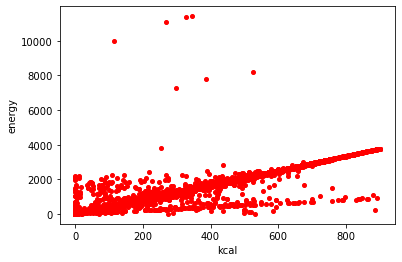

In [20]:
plt.xlabel('kcal')
plt.ylabel('energy')
plt.plot(data['energy-kcal_100g'], data['energy_100g'], 'ro', markersize=4)
plt.show()

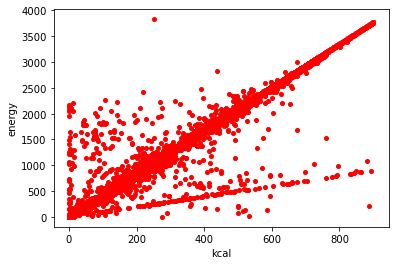

In [21]:
# delete outliers
data = data[(data['energy_100g'] <= 5000) | (data['energy_100g'].isnull())]

plt.xlabel('kcal')
plt.ylabel('energy')

plt.plot(data['energy-kcal_100g'], data['energy_100g'], 'ro', markersize=4)

plt.show()

#### 3.1.5 Predict kcal from energy

In [22]:
data = data[data['energy_100g'].notnull()]  

X = np.matrix([np.ones(data[data['energy-kcal_100g'].notnull()].shape[0]),
               data[data['energy-kcal_100g'].notnull()]['energy_100g'].values]).T
y = np.matrix(data[data['energy-kcal_100g'].notnull()]['energy-kcal_100g']).T

theta = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)

# fill null energy-kal_100g with the prediction from energy_100g column 
data['energy-kcal_100g'] = data.progress_apply(lambda x: theta.item(0) + x['energy_100g'] * theta.item(1) if pd.isnull(x['energy-kcal_100g']) else x['energy-kcal_100g'], axis=1)

100%|██████████████████████████████████████████████| 318898/318898 [00:04<00:00, 71642.32it/s]


## 4. Clean and export df

In [23]:
# delete outliers
data = data[data['energy-kcal_100g'] <= 900]

# drop nor necessary columns
data.drop(columns = ['sodium_100g','energy_100g'], inplace =True)

In [24]:
data.to_pickle('data_clean.pkl')